In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import LSTM,Dense, Bidirectional, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Import additional libraries for stacked LSTM
from keras.layers import TimeDistributed

In [7]:
# Import
df0 = pd.read_csv('Sample_Market_SKU_data.csv')
#NOTE: This is a horizontal, row-wise, time series dataset
df0.head()

,Market,Sales Product,21-Dec,22-Jan,22-Feb,22-Mar,22-Apr,22-May,22-Jun,22-Jul,...,24-Feb,24-Mar,24-Apr,24-May,24-Jun,24-Jul,24-Aug,24-Sep,24-Oct,24-Nov
0,AFRICA,AB12345,305,302,1503,1471,1583,2080,1490,672,...,787,1417,847,777,1128,1427,846,1475,1572,927
1,ASIA,AB12346,1892,1071,2065,841,1542,2142,691,103,...,615,1166,1538,1206,1129,290,426,762,1775,777
2,OCEANIA,AC12347,1728,1912,193,102,465,1279,1748,1817,...,1834,1392,1746,759,2258,2062,223,142,635,1295
3,EUROPE,AD12348,776,1499,660,1127,214,174,351,1184,...,561,316,1961,1005,1936,331,432,873,1753,870
4,NORTH AMERICA,AS12349,720,1101,1516,1395,967,44,638,521,...,975,1329,933,310,1533,1836,1644,2095,2268,1076


In [8]:
#Remove the non-numeric columns,
#Find the shape for tensor operations
df1=df0.iloc[:1,2:] #select the first time series AFRICA	AB12345	
df1.shape


(1, 36)

In [9]:
training_set0=np.array(df1)
training_set=training_set0.reshape(36,)
training_set.shape

(36,)

In [11]:
data=training_set
# Define lookback window
lookback_window =6
# Create input and output sequences
X = []
y = []
for i in range(lookback_window, len(data)):
    X.append(data[i - lookback_window:i])
    y.append(data[i])

X = np.array(X)
y = np.array(y)
# Split into training and testing sets
train_size = int(len(X) * 0.95)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [12]:
X_train.shape

(28, 6)

In [13]:
X_test.shape

(2, 6)

In [14]:
# Create a Vanilla LSTM model
## expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(lookback_window, 1)))
#model.add(TimeDistributed(Dense(units=20)))  # Add a TimeDistributed layer for stacked LSTM
#model.add(Bidirectional(LSTM(units=50, activation='relu', return_sequences=True), input_shape=(lookback_window, 1))) #Add a bi-layer for Bi-LSTM
#model.add(Dropout(0.2))  # Add a dropout layer to prevent overfitting
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=3, verbose=False)

# Make predictions on the test set
y_pred = model.predict(X_test)
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)




1/1 [==============================] - 0s 138ms/step
Mean Squared Error: 374889.5871910844
Mean Absolute Error: 445.8600158691406


In [15]:
# Predict the next 21 points with feedback
n_future = 21
y_future = []
x_pred = X[-1:, :]  # last observed input sequence
y_pred = y[-1]         # last observed target value

for i in range(n_future):

    # feed the last forecast back to the model as an input
    x_pred = np.append(x_pred[:, 1:], y_pred.reshape(1, 1), axis=1)

    # generate the next forecast
    y_pred = model.predict(x_pred)

    # save the forecast
    y_future.append(y_pred.flatten()[0])

print(x_pred)

1/1 [==============================] - 0s 24ms/step
[[485.89593506 449.44869995 430.74325562 404.47360229 385.9616394
  362.70950317]]


In [16]:
# Create a DataFrame for the predicted values
predictions_df2 = pd.DataFrame({'Predicted Values': y_future})
# Save the predictions to a CSV file and export it
predictions_df2.to_csv('predictions_VanillaLSTM_OUTPUT.csv', index=False)

In [17]:
#Create dataframes to visualise the forecast
#Create dataframes to visualise the forecast
data_df=pd.DataFrame(data)
y_future=pd.DataFrame(y_future)
#Add empty rows in y_future for historical data
df_zero=pd.DataFrame(np.zeros(len(data_df)))
#Concat empty rows with y_future for historical data
y_future2=pd.concat([df_zero,y_future],ignore_index=True,axis=0)
#Concat y_future2 with historical data
final=pd.concat([data_df,y_future2], ignore_index=True,axis=1)

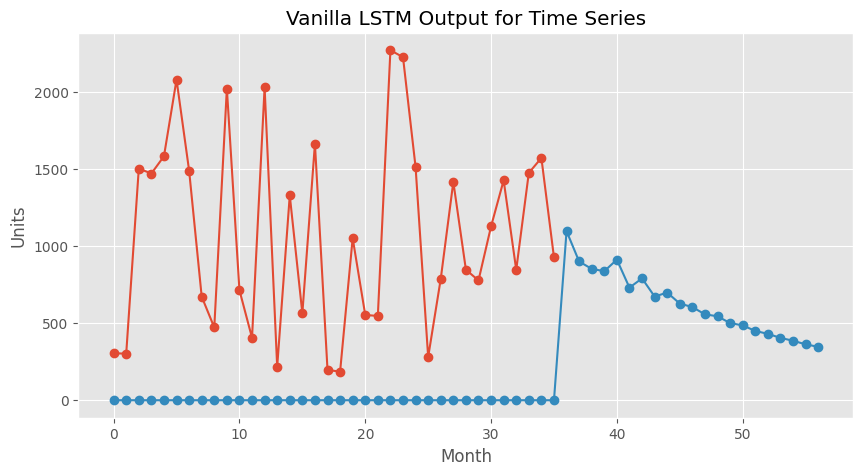

In [18]:
#Plot with the forecast with actuals
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(final, marker='o')
plt.title('Vanilla LSTM Output for Time Series')
plt.xlabel('Month')
plt.ylabel('Units')
plt.show()